# CIFAR_10 이미지 생성하기

Rubric

|평가문항|상세기준|
|---|---|
|1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
|2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.| gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
|3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다.|

In [1]:
!pip list | grep -E 'imageio|Pillow'

imageio                       2.25.1
imageio-ffmpeg                0.4.8
Pillow                        8.4.0


In [2]:
import tensorflow as tf
import imageio

print(tf.__version__)
print(imageio.__version__)

2.12.0
2.25.1


In [3]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
from tensorflow.keras.utils import plot_model

tensorflow 2.12.0


## Step1. 작업환경 구성하기

In [4]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label'])
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label'])
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return (train_x, train_y), (test_x, test_y)

## Step2. 데이터셋 구성하기

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170498071/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [7]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
train_x.shape

(50000, 32, 32, 3)

In [9]:
print(type(train_x))

<class 'numpy.ndarray'>


In [10]:
train_x = train_x.astype('float32')
train_x.shape

print(train_x.shape[0])

50000


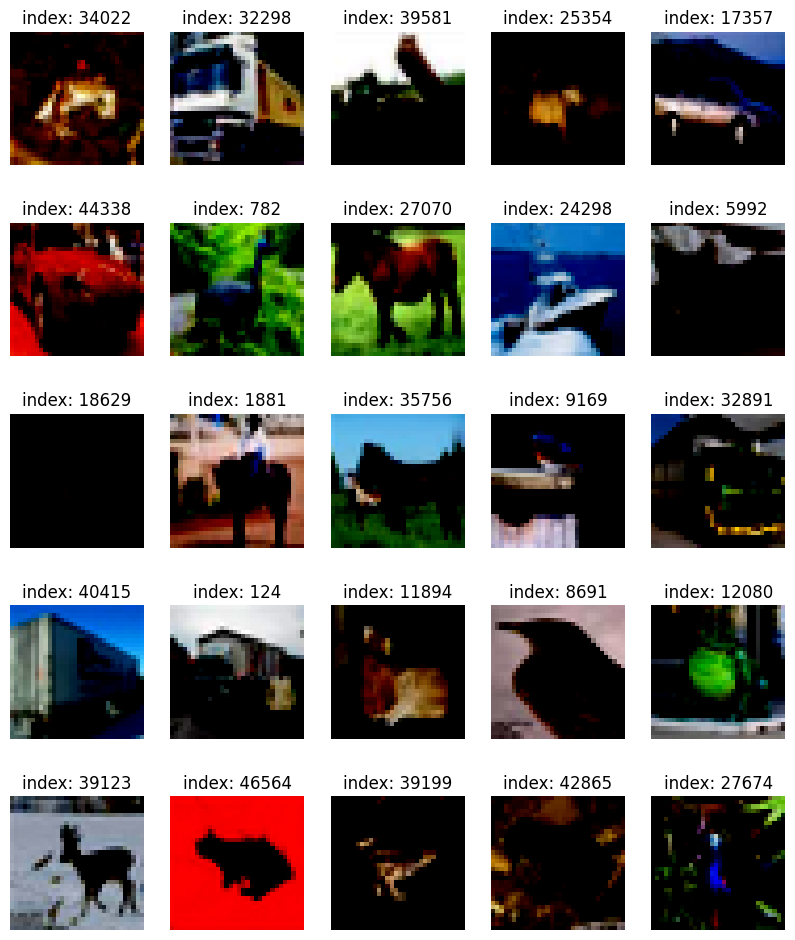

In [11]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[i].reshape(32,32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [21]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

In [19]:
def denorm(norm_img):
    return interval_mapping(norm_img, -1, 1, 0, 255).astype("uint8")

In [12]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Step3. 생성자 모델 구현하기

In [14]:
## (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))    ## 노이즈 입력
    model.add(layers.BatchNormalization())    ## 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU())
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())    ## 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU())
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())    ## 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU())
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2),
                                     padding='same', use_bias=False,
                                     activation='tanh'))

    return model

In [15]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [16]:
noise = tf.random.normal([1, 100])

In [17]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

(32, 32, 3)


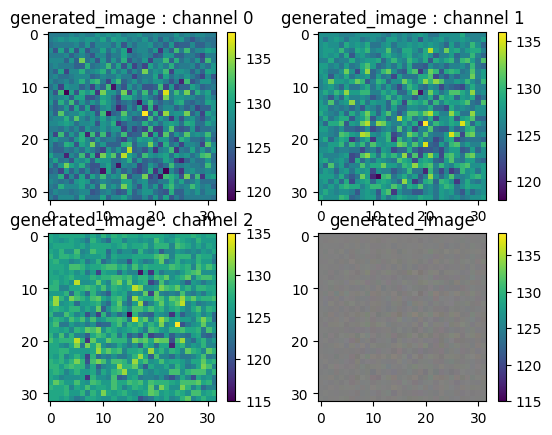

In [22]:
print(generated_image[0, :, :, ].shape)

# plt.imshow(denorm(generated_image[0, :, :, 2]))

## 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
for i in range(3):
    plt.subplot(2, 2, i + 1)
    plt.imshow(denorm(generated_image[0, :, :, i]))
    plt.title(f"generated_image : channel {i}")
    plt.colorbar()
#     plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(denorm(generated_image[0, :, :,]))
plt.title(f"generated_image")
plt.colorbar()
plt.show()

## Step4. 판별자 모델 구현하기

In [23]:
## (32, 32, 3)의 shape를 가진 이미지를 입력받는 판별자 모델 구현
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2),
                            padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())    ## 활성화 함수
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2),
                            padding='same'))
    model.add(layers.LeakyReLU())    ## 활성화 함수
    ##model.add(layers.Dropout(0.3))
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    ## 맨 마지막 Layer에 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없다.
    ## 즉, 구분자가 출력하는 값은 범위가 정해지지 않음 → 모든 실숫값을 가질 수 있다.

    return model

In [24]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [25]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00365854]], dtype=float32)>

## Step5. 손실함수와 최적화 함수 구현하기

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
## 생성자와 판별자의 손실함수(loss)를 구현 - 생성자
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
## 생성자와 판별자의 손실함수(loss)를 구현 - 판별자
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [29]:
## 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
def discriminator_accuracy(real_output, fake_output):

    real_accuracy = tf.reduce_mean(   ## ③：② 의 결과를 평균내어 이번 배치의 정확도(accuracy) 계산
        tf.cast(                      ## ②：①의 결과가 True → 1.0／False → 0.0 반환
            tf.math.greater_equal(    ## ①：각 원소가 0.5 이상인지 True／False
                real_output, tf.constant([0.5])), tf.float32))

    fake_accuracy = tf.reduce_mean(    ## ③：② 의 결과를 평균내어 이번 배치의 정확도(accuracy) 계산
        tf.cast(                       ## ②：①의 결과가 True → 1.0／False → 0.0 반환
            tf.math.less(              ## ①：각 원소가 0.5 미만인지 True／False
                fake_output, tf.constant([0.5])), tf.float32))

    return real_accuracy, fake_accuracy

In [30]:
## 생성자와 판별자를 최적화하는 optimizer를 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
##discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.SGD()

In [31]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## Step6. 훈련과정 상세 기능 구현하기

In [32]:
## 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현

## 데코레이터
@tf.function

def train_step(images):
    ## ① 입력데이터
    ## Real Image 역할을 할 images 한 세트를 입력으로 받음

    ## ② 생성자 입력 노이즈
    ## generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    ## ③ tf.GradientTape() 오픈
    ## tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        ## ④ generated_images 생성
        ## generator가 noise를 입력받은 후 generated_images 생성
        generated_images = generator(noise, training=True)

        ## ⑤ discriminator 판별
        ## discriminator가 Real Image인 images와 Fake Image인 generated_images를
        ## 각각 입력받은 후 real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        ## ⑥ loss 계산
        ## fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        ## ⑦ accuracy 계산
        ## fake_output, real_output으로 discriminator의 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    ## ⑧ gradient 계산
    ## gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    ## ⑨ 모델 학습
    ## 계산된 gradient를 optimizer에 입력해 가중치 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    ## ⑩ 리턴값
    ## 이번 스텝에 계산된 loss와 accuracy를 리턴
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [33]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(denorm(predictions[i, :, :, ]))
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [34]:
## 훈련 epoch마다
## 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake)
## 이미지 판별 accuracy 히스토리(history)를
## 그래프로 시각화하는 draw_train_history() 함수를 구현

from matplotlib.pylab import rcParams

# matlab 차트의 기본 크기를 16, 10으로 지정해 준다.
rcParams['figure.figsize'] = 16, 10

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(311)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(312)
    plt.plot(history['fake_accuracy'], color="dodgerblue")
    plt.ylabel('accuracy')
    plt.legend(['fake_accuracy'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(313)
    plt.plot(history['real_accuracy'], color="orange")
    plt.ylabel('accuracy')
    plt.legend(['real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [35]:
## training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

## Step7. 학습과정 진행하기

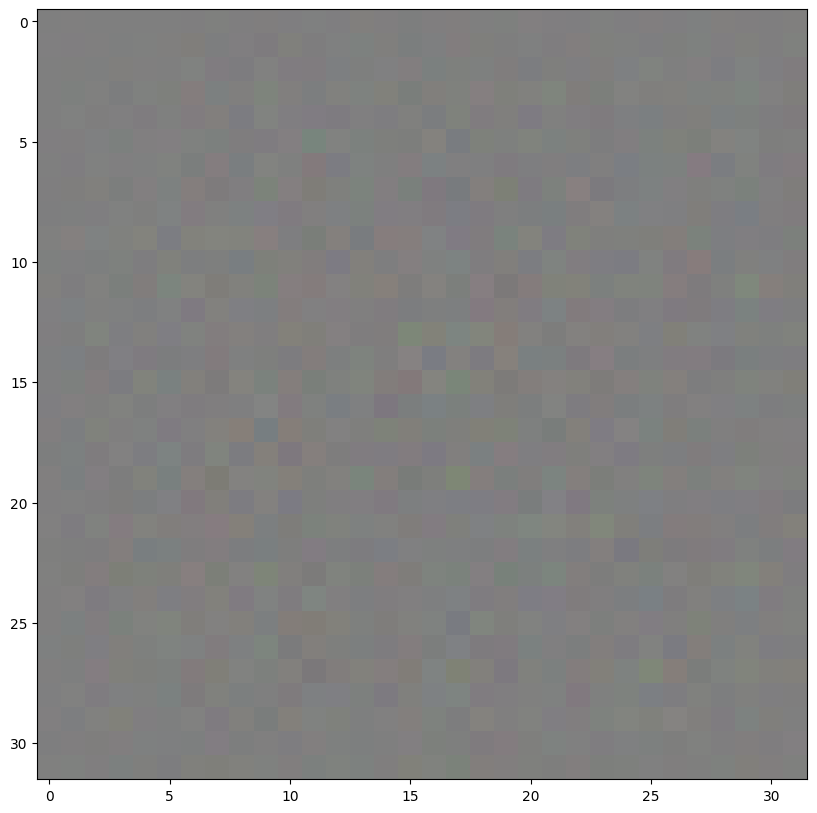

In [36]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것

## Step8. (optional) GAN 훈련과정 개선하기

## 회고

## Reference